In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import requests
import io

In [7]:
import os

# Check file exists and size
print(os.path.exists('/content/test_catvnoncat.h5'))
!file /content/test_catvnoncat.h5


False
/content/test_catvnoncat.h5: cannot open `/content/test_catvnoncat.h5' (No such file or directory)


train_X shape: (12288, 209)
train_y shape: (1, 209)
test_X shape: (12288, 50)
test_y shape: (1, 50)
classes: [b'non-cat' b'cat']


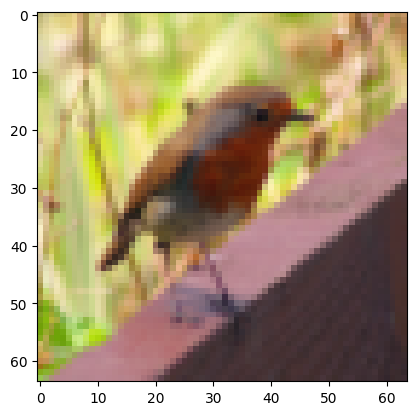

y = 0. It's a non-cat picture.


In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load training dataset
train_dataset = h5py.File('/content/train_catvnoncat.h5', "r")
test_dataset = h5py.File('/content/test_catvnoncat.h5', "r")

# Extract original images
train_X_orig = np.array(train_dataset['train_set_x'][:])   # shape (209, 64, 64, 3)
train_y_orig = np.array(train_dataset['train_set_y'][:])   # shape (209,)
test_X_orig = np.array(test_dataset['test_set_x'][:])      # shape (50, 64, 64, 3)
test_y_orig = np.array(test_dataset['test_set_y'][:])      # shape (50,)
classes = np.array(test_dataset['list_classes'][:])        # [b'non-cat' b'cat']

# Reshape labels to (1, m)
train_y = train_y_orig.reshape(1, -1)   # (1, 209)
test_y = test_y_orig.reshape(1, -1)     # (1, 50)

# Flatten and normalize the image data
train_X = train_X_orig.reshape(train_X_orig.shape[0], -1).T / 255.0   # (12288, 209)
test_X = test_X_orig.reshape(test_X_orig.shape[0], -1).T / 255.0      # (12288, 50)

# Print shapes
print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)
print("test_X shape:", test_X.shape)
print("test_y shape:", test_y.shape)
print("classes:", classes)

# Example: visualize one image
index = 10
plt.imshow(train_X_orig[index])  # use original for plotting
plt.show()

print("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")


In [14]:
np.random.seed(42)

In [15]:
def sigmoid(Z):
    """
    Implements the sigmoid activation function
    """
    A = 1/(1+np.exp(-np.clip(Z, -250, 250)))  # Clip to prevent overflow
    cache = Z
    return A, cache


In [16]:
def relu(Z):
    """
    Implements the ReLU activation function
    """
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [17]:
def sigmoid_backward(dA, cache):
    """
    Implements the backward propagation for sigmoid
    """
    Z = cache
    s = 1/(1+np.exp(-np.clip(Z, -250, 250)))
    dZ = dA * s * (1-s)
    return dZ

In [18]:
def relu_backward(dA, cache):
    """
    Implements the backward propagation for ReLU
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [19]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Initialize parameters for a 2-layer neural network

    Arguments:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- dictionary containing W1, b1, W2, b2
    """
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

In [20]:
def initialize_parameters_deep(layer_dims):
    """
    Initialize parameters for a deep neural network

    Arguments:
    layer_dims -- list containing the dimensions of each layer

    Returns:
    parameters -- dictionary containing parameters for all layers
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [21]:
def linear_forward(A, W, b):
    """
    Implement the linear part of forward propagation

    Arguments:
    A -- activations from previous layer
    W -- weights matrix
    b -- bias vector

    Returns:
    Z -- pre-activation parameter
    cache -- tuple containing A, W, b for backward pass
    """
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [22]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement forward propagation for LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer
    W -- weights matrix
    b -- bias vector
    activation -- "sigmoid" or "relu"

    Returns:
    A -- output of the activation function
    cache -- tuple containing linear_cache and activation_cache
    """
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

In [23]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID

    Arguments:
    X -- input data
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches for backward pass
    """
    caches = []
    A = X
    L = len(parameters) // 2

    # Forward propagation for [LINEAR -> RELU] * (L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)],
                                           parameters["b"+str(l)], activation="relu")
        caches.append(cache)

    # Forward propagation for LINEAR -> SIGMOID (output layer)
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)],
                                        parameters["b"+str(L)], activation="sigmoid")
    caches.append(cache)

    return AL, caches


In [24]:
def compute_cost(AL, Y):
    """
    Implement the cost function (cross-entropy)

    Arguments:
    AL -- probability vector from final layer
    Y -- true labels

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute cross-entropy cost
    cost = -np.sum(Y*np.log(AL + 1e-8) + (1-Y)*np.log(1-AL + 1e-8)) / m
    cost = np.squeeze(cost)

    return cost

In [25]:
def linear_backward(dZ, cache):
    """
    Implement backward propagation for linear layer

    Arguments:
    dZ -- gradient of cost with respect to linear output
    cache -- tuple (A_prev, W, b) from forward propagation

    Returns:
    dA_prev -- gradient with respect to activation of previous layer
    dW -- gradient with respect to W
    db -- gradient with respect to b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [26]:
def linear_backward(dZ, cache):
    """
    Implement backward propagation for linear layer

    Arguments:
    dZ -- gradient of cost with respect to linear output
    cache -- tuple (A_prev, W, b) from forward propagation

    Returns:
    dA_prev -- gradient with respect to activation of previous layer
    dW -- gradient with respect to W
    db -- gradient with respect to b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement backward propagation for LINEAR->ACTIVATION layer

    Arguments:
    dA -- post-activation gradient for current layer
    cache -- tuple (linear_cache, activation_cache)
    activation -- "sigmoid" or "relu"

    Returns:
    dA_prev -- gradient with respect to activation of previous layer
    dW -- gradient with respect to W
    db -- gradient with respect to b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [27]:
def L_model_backward(AL, Y, caches):
    """
    Implement backward propagation for [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID

    Arguments:
    AL -- probability vector, output of forward propagation
    Y -- true labels
    caches -- list of caches from forward propagation

    Returns:
    grads -- dictionary with gradients
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Initialize backpropagation
    dAL = - (np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [28]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- dictionary containing parameters
    grads -- dictionary containing gradients
    learning_rate -- learning rate for gradient descent

    Returns:
    parameters -- dictionary containing updated parameters
    """
    parameters = copy.deepcopy(parameters)
    L = len(parameters) // 2

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [29]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a L-layer neural network

    Arguments:
    X -- data, shape (n_x, number of examples)
    Y -- true labels, shape (1, number of examples)
    layers_dims -- list containing input size and each layer size
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, print the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model
    costs -- list of costs computed during training
    """
    np.random.seed(1)
    costs = []

    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation
        AL, caches = L_model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = L_model_backward(AL, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print(f"Cost after iteration {i}: {cost}")
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

In [30]:
def plot_costs(costs, learning_rate=0.0075):
    """
    Plot the cost function
    """
    plt.figure(figsize=(10, 6))
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f'Learning rate = {learning_rate}')
    plt.grid(True)
    plt.show()

In [31]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [32]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations

    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """

    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)

    # YOUR CODE ENDS HERE

    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        # YOUR CODE STARTS HERE
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")

        # YOUR CODE ENDS HERE

        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(A2, Y)

        # YOUR CODE ENDS HERE

        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        # YOUR CODE STARTS HERE
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")

        # YOUR CODE ENDS HERE

        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE

        parameters = update_parameters(parameters, grads, learning_rate)
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.693049715661845
Cost after iteration 100: 0.6464320754278845
Cost after iteration 200: 0.6325140451322061
Cost after iteration 300: 0.6015024729661068
Cost after iteration 400: 0.5601966126878601
Cost after iteration 500: 0.5158304595151496
Cost after iteration 600: 0.4754901140670726
Cost after iteration 700: 0.43391629843764157
Cost after iteration 800: 0.4007977371044622
Cost after iteration 900: 0.3580704852989664
Cost after iteration 1000: 0.33942813805420957
Cost after iteration 1100: 0.30527534852388305
Cost after iteration 1200: 0.2749137583577552
Cost after iteration 1300: 0.24681766823590803
Cost after iteration 1400: 0.19850733750375385
Cost after iteration 1500: 0.1744831686829961
Cost after iteration 1600: 0.17080761735469788
Cost after iteration 1700: 0.11306523414870503
Cost after iteration 1800: 0.09629425723333504
Cost after iteration 1900: 0.083426168545932
Cost after iteration 2000: 0.07439077612975836
Cost after iteration 2100: 0.0663074705

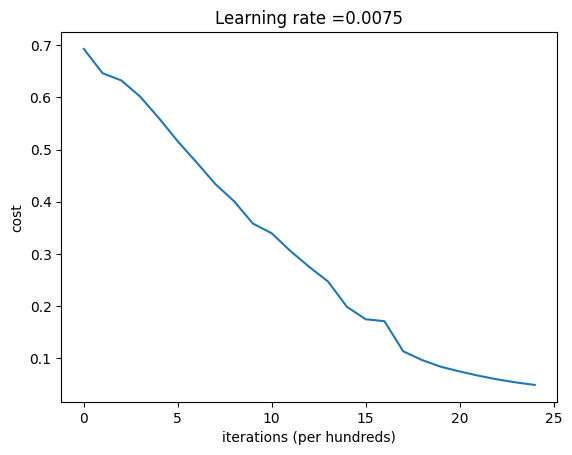

In [33]:
parameters, costs = two_layer_model(train_X, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [34]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [40]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost

    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)

    # YOUR CODE ENDS HERE

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)

        # YOUR CODE ENDS HERE

        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL, Y)

        # YOUR CODE ENDS HERE

        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)

        # YOUR CODE ENDS HERE

        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        update_parameters(parameters, grads, learning_rate)

        # YOUR CODE ENDS HERE

        # Print the cost every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

In [36]:
parameters, costs = L_layer_model(train_X, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

Cost after first iteration: 0.6931477526957882


In [39]:
parameters, costs = L_layer_model(train_X, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

Cost after first iteration: 0.6931477526957882


In [41]:
parameters, costs = L_layer_model(train_X, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.6931477526957882
Cost after iteration 100: 0.6931477526957882
Cost after iteration 200: 0.6931477526957882
Cost after iteration 300: 0.6931477526957882
Cost after iteration 400: 0.6931477526957882


KeyboardInterrupt: 